# Uplift Modeling


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn import metrics

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
# pip install --user "pyrsm>=0.7.4"

In [3]:
rsm.__version__

'0.7.5'

In [4]:
## loading the data - this dataset must NOT be changed
cg_organic_control = pd.read_pickle("data/cg_organic_control.pkl")
rsm.describe(cg_organic_control)

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Uplift Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")


In [5]:
## loading the data - this dataset must NOT be changed
cg_ad_random = pd.read_pickle("data/cg_ad_random.pkl")
rsm.describe(cg_ad_random)

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Uplift Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")

In [6]:
# Add a variable "ad" to cg_ad_random and set its value to 1 for all rows
cg_ad_random['ad'] = 1

In [7]:
# Add a variable "ad" to cg_organic_control and set its value to 0 for all rows
cg_organic_control['ad'] = 0

In [8]:
# Combine the two datasets
cg_rct_stacked = pd.concat([cg_organic_control, cg_ad_random]).reset_index(drop=True)
cg_rct_stacked

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,ad
0,no,7,18,0,124,0,81,0,yes,no,...,0,0,4,no,yes,3,2101,no,no,0
1,no,10,3,2,60,0,18,479,no,no,...,7,0,0,yes,no,7,1644,yes,no,0
2,no,2,1,0,0,0,0,0,no,no,...,0,0,2,no,no,8,3197,yes,yes,0
3,no,2,11,1,125,0,73,217,no,no,...,0,0,0,yes,no,6,913,no,no,0
4,no,8,15,0,0,0,6,51,yes,no,...,0,2,1,yes,no,21,2009,yes,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,no,5,1,0,0,0,0,0,no,no,...,0,0,0,yes,yes,11,2374,no,no,1
59996,no,9,12,0,78,0,59,1,yes,no,...,0,0,5,yes,no,2,1978,yes,no,1
59997,no,9,19,1,271,0,71,95,yes,no,...,0,0,3,no,no,2,2831,yes,yes,1
59998,no,10,23,0,76,6,20,107,no,no,...,0,1,0,no,no,9,3197,yes,no,1


In [9]:
train, test = train_test_split(
    cg_rct_stacked,
    test_size=0.3,
    random_state=1234,
    stratify=cg_rct_stacked[["converted", "ad"]]
)
print(train.ad.value_counts())
print(test.ad.value_counts())


1    21000
0    21000
Name: ad, dtype: int64
1    9000
0    9000
Name: ad, dtype: int64


In [10]:
cg_rct_stacked["training"] = 0
cg_rct_stacked.loc[train.index, "training"] = 1

In [11]:
pd.crosstab(
    cg_rct_stacked.converted, [cg_rct_stacked.ad, cg_rct_stacked.training], normalize="columns"
).round(2)

ad            0           1      
training      0     1     0     1
converted                        
yes        0.06  0.06  0.13  0.13
no         0.94  0.94  0.87  0.87

In [12]:
cg_rct_stacked.head(2)

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,ad,training
0,no,7,18,0,124,0,81,0,yes,no,...,0,4,no,yes,3,2101,no,no,0,1
1,no,10,3,2,60,0,18,479,no,no,...,0,0,yes,no,7,1644,yes,no,0,1


In [13]:
# create a variable called 'converted_yes' that has value 1 when converted == 'yes', has value 0 when converted == 'no' and has value np.nan when converted.isna() is True
cg_rct_stacked["converted_yes"] = np.where(cg_rct_stacked['converted'] == 'yes', 
                                        1 ,np.where(cg_rct_stacked['converted']  == 'no', 0, 
                                        np.where(cg_rct_stacked['converted'].isna(), np.nan, np.nan)))

In [14]:
predictors = ['GameLevel', 'NumGameDays', 'NumGameDays4Plus',
       'NumInGameMessagesSent', 'NumSpaceHeroBadges',
       'NumFriendRequestIgnored', 'NumFriends', 'AcquiredSpaceship',
       'AcquiredIonWeapon', 'TimesLostSpaceship', 'TimesKilled',
       'TimesCaptain', 'TimesNavigator', 'PurchasedCoinPackSmall',
       'PurchasedCoinPackLarge', 'NumAdsClicked', 'DaysUser', 'UserConsole',
       'UserHasOldOS']
response = 'converted_yes'

X = cg_rct_stacked[predictors]
y = cg_rct_stacked[response]

# Create dummy variables for the categorical column
dummies = pd.get_dummies(X, columns=['AcquiredSpaceship','AcquiredIonWeapon',
                            'PurchasedCoinPackSmall','PurchasedCoinPackLarge',
                            'UserConsole','UserHasOldOS'],\
       drop_first=True)
# Add the dummy variables to the original DataFrame
X = pd.concat([X, dummies], axis=1)
X.drop(['AcquiredSpaceship','AcquiredIonWeapon','PurchasedCoinPackSmall',
'PurchasedCoinPackLarge','UserConsole','UserHasOldOS'], axis=1, inplace=True)


### baseline models: Estimate simple logistic regression models on treatment(ad==1) and control(ad==0) sample to use as a 

In [15]:
df_for_lr = pd.concat([y, X], axis=1)

In [16]:
lr_treatment = sm.GLM(y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)],\
    X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)],
    family=Binomial(link=logit())
).fit()

print(lr_treatment.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          converted_yes   No. Observations:                21000
Model:                            GLM   Df Residuals:                    20981
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7817.2
Date:                Thu, 23 Feb 2023   Deviance:                       15634.
Time:                        07:05:13   Pearson chi2:                 2.29e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02946
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
GameLevel           

In [17]:
print(rsm.model_fit(lr_treatment))


Pseudo R-squared (McFadden): 0.039
Pseudo R-squared (McFadden adjusted): 0.036
Area under the RO Curve (AUC): 0.651
Log-likelihood: -7817.221, AIC: 15672.441, BIC: 15823.535
Chi-squared: 22904.784 df(18), p.value < 0.001 
Nr obs: 21,000

None


In [18]:
lr_control = sm.GLM(y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)],\
    X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)],
    family=Binomial(link=logit())
).fit()

print(lr_control.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          converted_yes   No. Observations:                21000
Model:                            GLM   Df Residuals:                    20981
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4090.8
Date:                Thu, 23 Feb 2023   Deviance:                       8181.6
Time:                        07:05:14   Pearson chi2:                 4.98e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04578
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
GameLevel           

In [19]:
print(rsm.model_fit(lr_control))


Pseudo R-squared (McFadden): 0.107
Pseudo R-squared (McFadden adjusted): 0.103
Area under the RO Curve (AUC): 0.726
Log-likelihood: -4090.812, AIC: 8219.623, BIC: 8370.716
Chi-squared: 49785.705 df(18), p.value < 0.001 
Nr obs: 21,000

None


In [20]:
cg_rct_stacked["pred_treatment_lr"] = lr_treatment.predict(X)
cg_rct_stacked["pred_control_lr"] = lr_control.predict(X)

In [21]:
cond_ad_test = (cg_rct_stacked.training == 0) & (cg_rct_stacked.ad == 1)
cond_control_test = (cg_rct_stacked.training == 0) & (cg_rct_stacked.ad == 0)

test_lr_treatment_auc = rsm.auc(cg_rct_stacked[cond_ad_test].converted_yes, 
                                cg_rct_stacked[cond_ad_test].pred_treatment_lr, 1)

test_lr_control_auc = rsm.auc(cg_rct_stacked[cond_control_test].converted_yes, 
                        cg_rct_stacked[cond_control_test].pred_control_lr, 1)
                        
print('test_lr_treatment_auc AUC:', test_lr_treatment_auc)
print('test_lr_control_auc AUC:', test_lr_control_auc)

test_lr_treatment_auc AUC: 0.6332815395847764
test_lr_control_auc AUC: 0.705106197720311


#### Train a random forest model on rf_treatment ad==1

In [22]:
# Initialize the Random Forest classifier with default parameters
rf_treatment = RandomForestClassifier()

# Define a parameter grid containing the hyperparameters to be tuned using grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': range(5,10) # use array of numbers, most influential parameter between 3 and 10
}

# # Create an instance of the GridSearchCV() class and pass the random forest model and parameter grid as arguments
# grid_search = GridSearchCV(rf_treatment, param_grid, cv=5)

# # Fit the grid search object to the training data
# grid_search.fit(X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)], 
#                 y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)])

# # Get the best parameters
# best_parameters = grid_search.best_params_
# print(best_parameters)

# rf_treatment = RandomForestClassifier(n_estimators=best_parameters['n_estimators'],
#                     max_depth=5,
#                     max_features=best_parameters['max_features'],
#                     oob_score = True,
#                     n_jobs = -1)

rf_treatment = RandomForestClassifier(n_estimators=500,
                    max_depth=5,
                    max_features=6,
                    oob_score = True,
                    n_jobs = -1)

# Train the model on the training data
rf_treatment.fit(X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)],
                y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)])

pred = rf_treatment.oob_decision_function_

fpr, tpr, thresholds = metrics.roc_curve(y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)], 
                                        pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7716916523320058

#### rf_control ad==0

In [23]:
# Initialize the Random Forest classifier with default parameters
rf_control = RandomForestClassifier()

# Define a parameter grid containing the hyperparameters to be tuned using grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': range(5,10)
}

# # Create an instance of the GridSearchCV() class and pass the random forest model and parameter grid as arguments
# grid_search = GridSearchCV(rf_control, param_grid, cv=5)

# # Fit the grid search object to the training data
# grid_search.fit(X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)], y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)])

# # Get the best parameters
# best_parameters = grid_search.best_params_
# print(best_parameters)

# rf_control = RandomForestClassifier(n_estimators=best_parameters['n_estimators'],
#                     max_depth=5,
#                     max_features=best_parameters['max_features'],
#                     oob_score = True,
#                     n_jobs = -1)

rf_control = RandomForestClassifier(n_estimators=500,
                    max_depth=5,
                    max_features=6,
                    oob_score = True,
                    n_jobs = -1)


# Train the model on the training data
rf_control.fit(X[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)],
                    y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)])

pred = rf_control.oob_decision_function_

fpr, tpr, thresholds = metrics.roc_curve(y[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)], 
                                        pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.8699381910731753

In [24]:
cg_rct_stacked["pred_treatment"] =rf_treatment.predict_proba(X)[:,1]
cg_rct_stacked["pred_control"] =rf_control.predict_proba(X)[:,1]

AUC for random forest on test sets for treatment and control

In [25]:
cond_ad_test = (cg_rct_stacked.training == 0) & (cg_rct_stacked.ad == 1)
cond_control_test = (cg_rct_stacked.training == 0) & (cg_rct_stacked.ad == 0)

test_lr_treatment_auc = rsm.auc(cg_rct_stacked[cond_ad_test].converted_yes, 
                                cg_rct_stacked[cond_ad_test].pred_treatment, 1)

test_lr_control_auc = rsm.auc(cg_rct_stacked[cond_control_test].converted_yes, 
                        cg_rct_stacked[cond_control_test].pred_control, 1)
                        
print('test RF treatment_auc AUC:', test_lr_treatment_auc)
print('test RF control_auc AUC:', test_lr_control_auc)

test RF treatment_auc AUC: 0.7678853870664814
test RF control_auc AUC: 0.8666398518496701


Check the fit of the models using gains plot

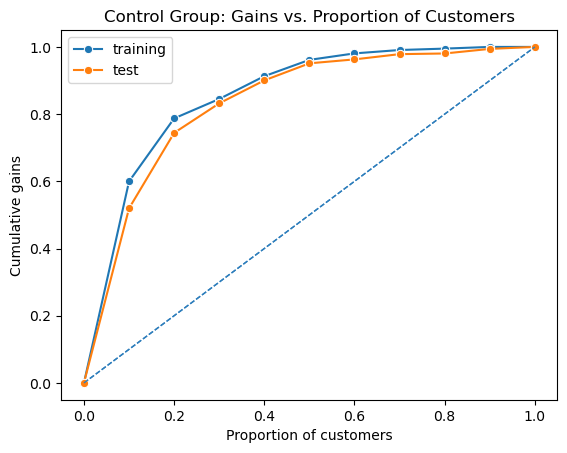

In [26]:
fig_train = rsm.gains_plot(cg_rct_stacked.query("training == 1 and ad == 0"),rvar='converted_yes',
lev=1,pred='pred_control',qnt=10, label = "training")
fig_test = rsm.gains_plot(cg_rct_stacked.query("training == 0 and ad == 0"),rvar='converted_yes',
lev=1,pred='pred_control',qnt=10, label = "test")
plt.title('Control Group: Gains vs. Proportion of Customers')
plt.show()

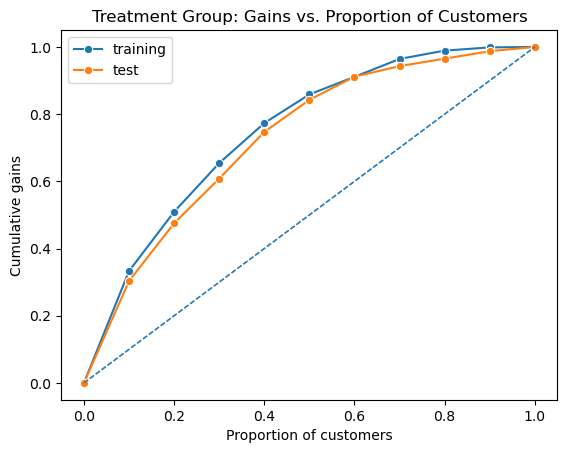

In [27]:
fig_train = rsm.gains_plot(cg_rct_stacked.query("training == 1 and ad == 1"),rvar='converted_yes',
lev=1,pred='pred_treatment',qnt=10, label = "training")
fig_test = rsm.gains_plot(cg_rct_stacked.query("training == 0 and ad == 1"),rvar='converted_yes',
lev=1,pred='pred_treatment',qnt=10, label = "test")
plt.title('Treatment Group: Gains vs. Proportion of Customers')
plt.show()

We got the best fits for train and test for both treatment and control groups using gridsearch on RF classifier models. We will now proceed to uplift calculations

#### Create predictions and the uplift score for each customer in the test data 

For each customer in the test data (regardless of whether they were in the treatment group or the control group), we get `Prob(yes | treated)` and `Prob(yes | not treated)` from the above models and then take their difference (i.e., the uplift score):

In [28]:
cg_rct_stacked["uplift_score"] = (
    cg_rct_stacked.pred_treatment - cg_rct_stacked.pred_control
)

In [29]:
cg_rct_stacked.head(2)

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,UserConsole,UserHasOldOS,ad,training,converted_yes,pred_treatment_lr,pred_control_lr,pred_treatment,pred_control,uplift_score
0,no,7,18,0,124,0,81,0,yes,no,...,no,no,0,1,0.0,0.147395,0.045323,0.023282,0.007452,0.015830
1,no,10,3,2,60,0,18,479,no,no,...,yes,no,0,1,0.0,0.215640,0.052438,0.191083,0.068536,0.122548


Sort the data on uplift score from highest to lowest and select a few key columns.

In [30]:
(
    cg_rct_stacked[
        ["converted", "ad", "training", "pred_treatment", "pred_control", "uplift_score"]
    ]
    .query("training == 0")
    .sort_values("uplift_score", ascending=False)
)

,converted,ad,training,pred_treatment,pred_control,uplift_score
2299,no,0,0,0.599143,0.108663,0.490480
8278,yes,0,0,0.612684,0.126138,0.486546
30469,yes,1,0,0.608567,0.123991,0.484576
7625,no,0,0,0.561100,0.079146,0.481954
4982,no,0,0,0.581381,0.099467,0.481913
...,...,...,...,...,...,...
603,yes,0,0,0.135799,0.538901,-0.403101
43236,no,1,0,0.136776,0.540355,-0.403579
44411,no,1,0,0.136531,0.547934,-0.411403
53293,no,1,0,0.126544,0.544776,-0.418232


### Evaluate the performance of the uplift model

In [31]:
# def uplift_tab(df, rvar, lev, pred, tvar, tlev, qnt=10):
    # Parameters
    # ----------
    # df : Pandas dataframe
    # rvar : str
    #     Name of the response variable column in df
    # lev : str
    #     Name of the 'success' level in rvar
    # pred : str
    #     Name of the column in df with model predictions
    # tvar : str
    #     Name of the treatment variable column in df
    # tlev : str
    #     Name of the 'success' level in tvar
    # qnt : int
    #     Number of quantiles to create

In [32]:
tab = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"), rvar="converted", lev="yes", 
    pred="uplift_score", tvar="ad", tlev=1, qnt=20
)
# tab.to_csv("../cg_rct_stacked.csv")
tab

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_score,1,0.05,207,450,72,592,152.270270,1.691892,0.338378
1,uplift_score,2,0.10,341,900,96,1132,264.674912,2.940832,0.253333
2,uplift_score,3,0.15,442,1350,115,1687,349.972733,3.888586,0.190210
3,uplift_score,4,0.20,565,1800,153,2249,442.545576,4.917173,0.205718
4,uplift_score,5,0.25,655,2250,181,2675,502.757009,5.586189,0.134272
5,uplift_score,6,0.30,721,2700,197,3187,554.103232,6.156703,0.115417
6,uplift_score,7,0.35,773,3150,211,3648,590.804276,6.564492,0.085187
7,uplift_score,8,0.40,813,3600,226,4206,619.562054,6.884023,0.062007
8,uplift_score,9,0.45,861,4050,239,4698,654.965517,7.277395,0.080244
9,uplift_score,10,0.50,906,4500,253,5186,686.466641,7.627407,0.071311


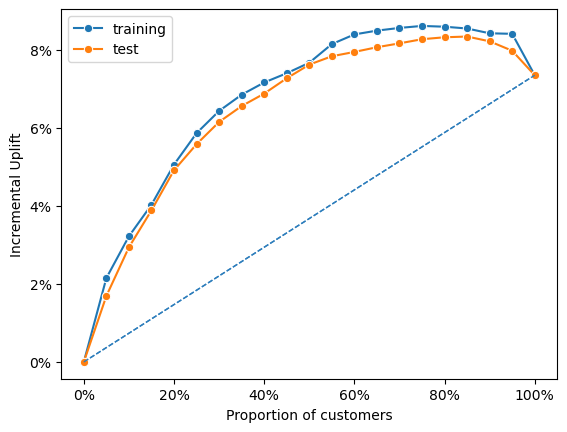

In [33]:
fig2 = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 1"), "converted", "yes", "uplift_score", "ad", 1,20,label='training'
)

fig1 = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"), "converted", "yes", "uplift_score", "ad", 1,20,label='test'
)

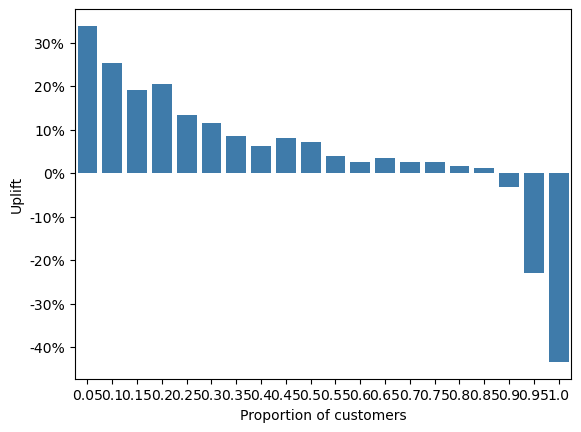

In [34]:
fig1 = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"), 
    "converted", "yes", "uplift_score", "ad", 1, 20
)

# Interpretation of plots and tab:

1. We gain the maximum cumulative uplift when we traget around 85% of the customers in the test set. This can be seen from the incremental uplift plot and the uplift tab
2. When we target more than 85% customers, our cumulative uplift starts declining. This can be clearly seen from the uplit plot and tab.
3. There's a decreasing trend of upflit as the decile increases

In [35]:
cost = 1.5
revenues = 14.99

In [36]:
breakeven = cost/revenues

In [37]:
target_rate = 30000 / 120000
target_number = 9000 * target_rate
print('target_number for test set is {:.0f} customer:'.format(target_number))

target_number for test set is 2250 customer:


In [38]:
incremental_resp = tab[tab['T_n']==target_number].incremental_resp.item()
incremental_resp

502.75700934579436

In [39]:
extrapolated_incremental_resp = incremental_resp * 120000/9000
extrapolated_incremental_resp

6703.4267912772575

In [49]:
incremental_profit = revenues * extrapolated_incremental_resp - cost*30000
print("Incremental profit from targeting the best 30,000 customers using uplift score: ${:.2f}".format(incremental_profit))


Incremental profit from targeting the best 30,000 customers using uplift score: $55484.37


In [43]:
tab_propensity = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"), rvar="converted", lev="yes", 
    pred="pred_treatment", tvar="ad", tlev=1, qnt=20
)
# tab.to_csv("../cg_rct_stacked.csv")
tab_propensity

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_treatment,1,0.05,215,450,81,625,156.680000,1.740889,0.348178
1,pred_treatment,2,0.10,356,900,116,1053,256.854701,2.853941,0.231558
2,pred_treatment,3,0.15,473,1350,142,1629,355.320442,3.948005,0.214861
3,pred_treatment,4,0.20,558,1800,182,2100,402.000000,4.466667,0.103963
4,pred_treatment,5,0.25,649,2250,239,2509,434.671582,4.829684,0.062858
5,pred_treatment,6,0.30,714,2700,311,2890,423.446367,4.704960,-0.044532
6,pred_treatment,7,0.35,801,3150,369,3179,435.366153,4.837402,-0.007359
7,pred_treatment,8,0.40,877,3600,433,3508,432.644242,4.807158,-0.025640
8,pred_treatment,9,0.45,936,4050,471,3942,452.095890,5.023288,0.043554
9,pred_treatment,10,0.50,989,4500,483,4396,494.573248,5.495258,0.091346


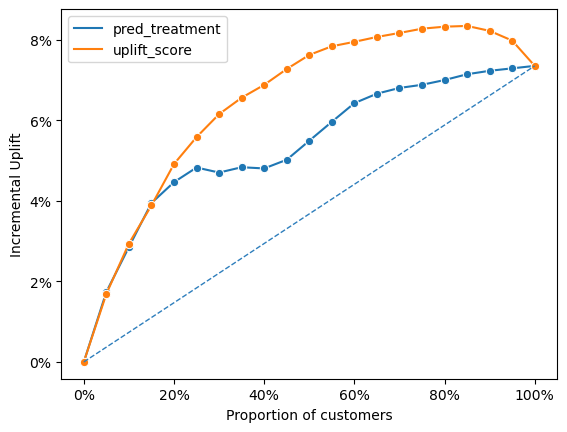

In [44]:
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",
    "yes",
    ["pred_treatment","uplift_score"],
    "ad",
    1,20
)

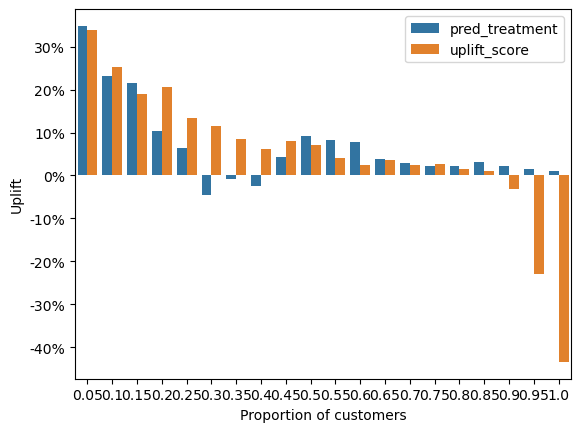

In [45]:
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",
    "yes",
    ["pred_treatment","uplift_score"],
    "ad",
    1,20
)

# Interpretation of plots and tab:

1. We see negative uplift from the propensity model in 6th, 7th and 8th bins. 
2. Uplift score is higher than the pred_treatment probabilities for the fist 10 bins. After that the trend reverses

In [46]:
incremental_resp2 = tab_propensity[tab_propensity['T_n']==target_number].incremental_resp.item()
incremental_resp2

434.67158230370666

In [47]:
extrapolated_incremental_resp2 = incremental_resp2 * 120000/9000
extrapolated_incremental_resp2

5795.621097382756

In [76]:
incremental_profit2 = revenues * extrapolated_incremental_resp2 - cost*30000
print("Incremental profit from targeting the best 30,000 customers using propensity score: ${:.2f}".format(incremental_profit2))
print(f"We would make ${round(incremental_profit - incremental_profit2)} more using an uplift rather than a propensity model")


Incremental profit from targeting the best 30,000 customers using propensity score: $41876.36
We would make $13608 more using an uplift rather than a propensity model


# Part II: Targeting the optimal percent of customers



If we were to select customers to maximise profits using propensity model, apply breakeven cut off on pred_treatment on the test treatment data. Take the count of these customers to target. This count can be converted to percentage by dividing by total number of rows in the data

In [64]:
cg_rct_stacked["breakeven_flag"] = cg_rct_stacked["pred_treatment"] > breakeven

# count the number of customers to target based on breakeven threshold in the test set
target_num = cg_rct_stacked.query("training ==0 and ad == 1")["breakeven_flag"].sum()
target_num_pct = cg_rct_stacked.query("training ==0 and ad == 1")["breakeven_flag"].mean()
print(f"Percentage of customers to target to maximise profits using propensity model based on breakeven: {round(target_num_pct*100,2)}%")

Percentage of customers to target to maximise profits using propensity model based on breakeven: 64.33%




If we were to select customers to maximise incremental profit using uplift model, apply breakeven cut off on uplift_score on the test treatment data. Take the count of these customers to target. This count can be converted to percentage by dividing by total number of rows in the data

In [52]:
cg_rct_stacked["breakeven_flag_uplift"] = cg_rct_stacked["uplift_score"] > breakeven

# count the number of customers to target based on breakeven threshold in the test set
target_num_uplift = cg_rct_stacked.query("training ==0 and ad == 1")["breakeven_flag_uplift"].sum()
target_num_pct_uplift = target_num_uplift/(cg_rct_stacked.query("training ==0 and ad == 1").shape[0])
print(f"Percantage of customers to target to maximise incremental profit using uplift score based on breakeven: {round(target_num_pct_uplift*100,2)}%")

Percantage of customers to target to maximise incremental profit using uplift score based on breakeven: 21.49%


Propensity Model Profit

In [53]:
# trace this back to the uplift tab for propensity model. 
nearest_decile_cum_prop = 5 * round(target_num_pct*100/5)
nearest_decile_cum_prop
inc_resp_rate = tab_propensity[
    tab_propensity["cum_prop"] == nearest_decile_cum_prop/100]["incremental_resp"].item()


In [71]:
inc_resp_rate

599.8285280728376

In [54]:
extrapolated_incremental_prop = inc_resp_rate * 120000/9000
extrapolated_incremental_prop

7997.713707637835

In [73]:
incremental_prof_prop = revenues * extrapolated_incremental_prop - cost*120000*target_num_pct
print(f"Incremental profit from targeting the best {round(target_num_pct*100,2)}% customers using propensity model: ${round(incremental_prof_prop)}")

Incremental profit from targeting the best 64.33% customers using propensity model: $4086


Uplift Model profit

In [56]:
# trace this back to the uplift tab for propensity model. 
nearest_decile_cum_prop_uplift = 5 * round(target_num_pct_uplift*100/5)
inc_resp_rate_uplift = tab[
    tab["cum_prop"] == nearest_decile_cum_prop/100]["incremental_resp"].item()


In [57]:
extrapolated_incremental_uplift = inc_resp_rate_uplift * 120000/9000
extrapolated_incremental_uplift

9688.555572526857

In [61]:
incremental_prof_uplift = revenues * extrapolated_incremental_uplift - cost*120000*target_num_pct_uplift
print(f"Incremental profit from targeting the best {round(target_num_pct_uplift*100,2)}% customers using uplift model: ${round(incremental_prof_uplift)}")

Incremental profit from targeting the best 21.49% customers using uplift model: $106551


In [62]:
if incremental_prof_uplift > incremental_prof_prop:
    print(f"""Incremental profits from Uplift model are BETTER than propensity
    model by {round(incremental_prof_uplift - incremental_prof_prop)} dollars""")
else:
    print(f"""Incremental profits from Uplift model are LOWER than propensity
    model by {round(incremental_prof_prop - incremental_prof_uplift)} dollars""")

Incremental profits from Uplift model are BETTER than propensity
    model by 102466 dollars




uplift models are typically better suited for predicting incremental profits. Reasons:

1. Focus on treatment effect: Unlike propensity models that focus on predicting the probability of a customer taking a specific action regardless of whether they are treated or not, uplift models focus on predicting the incremental impact of a treatment. By identifying which customers are most likely to respond positively to a treatment, uplift models can help companies target those customers who will generate the most incremental revenue. This approach tends to be more effective in identifying customers who are most likely to generate incremental profits.

2. Reduction of cannibalization: Propensity models only focus on predicting customer behavior, regardless of whether they would have taken the desired action anyway. This means that propensity models can include customers who would have made a purchase without being targeted, resulting in cannibalization of revenue. Uplift models help to minimize this cannibalization effect by identifying only those customers who are most likely to make a purchase as a result of the treatment, resulting in a higher incremental profit.




